# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
!pip install pydrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
def get_file_names():

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  file_list = drive.ListFile({'q': "'1YcgZRsNxIBYTx1D7Y4_FfqhsmdYSPiuy' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
    
    
    
def get_file_into_colab(file_id,file_name):
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  amazon = drive.CreateFile({'id': file_id})
  amazon.GetContentFile(file_name)
  print(" Congrats ! Now You can import file into Pandas DataFrame !")

In [0]:
get_file_names()

In [0]:

get_file_into_colab('13IEHA4nFlFbQNcY4JwGtmx-spmZhJVU6','Amazon.csv')

 Congrats ! Now You can import file into Pandas DataFrame !


In [0]:
"""from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

word_string="CoreFlex Solutions Pvt Ltd"
#Convert all the required text into a single string here 
#and store them in word_string

#you can specify fonts, stopwords, background color and other options

wordcloud = WordCloud().generate_from_text(word_string)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()"""

'from wordcloud import WordCloud, STOPWORDS\nimport matplotlib.pyplot as plt\n\nword_string="CoreFlex Solutions Pvt Ltd"\n#Convert all the required text into a single string here \n#and store them in word_string\n\n#you can specify fonts, stopwords, background color and other options\n\nwordcloud = WordCloud().generate_from_text(word_string)\n\n\nplt.imshow(wordcloud)\nplt.axis(\'off\')\nplt.show()'

In [0]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_csv("Amazon.csv") 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525773, 11)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Successfully converted SCORE column into categorical column i.e 1's & 0's

1-> Positive Reviews & 

0-> Negative Reviews

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364161, 11)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.26201992114468

This indicates that  **31%** of data were duplicate entries.

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows should also be removed

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364159, 11)


1    307054
0     57105
Name: Score, dtype: int64

There are **~307k Positive** Reviews & **~57k Negative** Reviews

In [0]:
final['Time']=pd.to_datetime(final['Time'])
print(final.head(2))
final.sort_values(by='Time',inplace=True)
final.head(3)

        Unnamed: 0  ...                                               Text
138694      138694  ...  Summary:  A young boy describes the usefulness...
138675      138675  ...  A very entertaining rhyming story--cleaver and...

[2 rows x 11 columns]


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138695,138695,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138672,138672,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417806,417806,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


To perform TBS we have sorted the Data using Time column & prior to thaat we have converted time column to datetime object type.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
The 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
The 

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought some of this tea when I was in Seattle and I have been dying to get more It really is the best tea I have ever had It is great hot or cold 


**Observation:-** Look at all above print statements, we can notice that, after processing the text using different techniques like removing tags, converting into lowercase, removing numbers, removing stopwords, etc... we have got the desired form of a text i.e cleaned text.

Lets Perform all this preprocessing techniques on complete dataset (text)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_text.append(sentance.strip())

100%|██████████| 364159/364159 [02:20<00:00, 2584.11it/s]


In [0]:
preprocessed_reviews_text[1500]

'bought tea seattle dying get really best tea ever great hot cold'

Above is the processed TEXT column for one single review (row)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 364159/364159 [01:33<00:00, 3882.47it/s]


# [3.3] Combining Text & Summary Columns into Single Text 

In [0]:
# lets combine TEXT and SUMMARY columns into single text column
final_df=pd.DataFrame(preprocessed_reviews_text,columns=['Text'])
final_df['Summary']=preprocessed_reviews_summary
final_df.head()
final_df=final_df.apply(lambda x:" ".join(x),axis=1)
final_df=pd.DataFrame(final_df)
final_df.columns=['Text']
print(final_df.head())
print("*************************")
final_df.iloc[0,0]



                                                Text
0  witty little book makes son laugh loud recite ...
1  remember seeing show aired television years ag...
2  beetlejuice well written movie everything exce...
3  twist rumplestiskin captured film starring mic...
4  beetlejuice excellent funny movie keaton hilar...
*************************


'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college every book educational'

We have successfully concatenated TEXT & SUMMARY columns into single text column.

Have a look at the print statement which is the concatenation of TEXT & SUMMARY for single row (0th row)

In [0]:
# lets sample top 50k datapoints, 40k for training the model and 10k for testing the model i.e train & test datapoints
train_df=pd.DataFrame(final_df['Text'][:60000].copy())
test_df=pd.DataFrame(final_df['Text'][60000:80000].copy())
print(train_df.info())
print(test_df.info())
train_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 1 columns):
Text    60000 non-null object
dtypes: object(1)
memory usage: 468.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 60000 to 79999
Data columns (total 1 columns):
Text    20000 non-null object
dtypes: object(1)
memory usage: 156.3+ KB
None


,Text
0,witty little book makes son laugh loud recite ...
1,remember seeing show aired television years ag...


# [4] Featurization

## [4.1] BOW

In [0]:
#BoW for train dataset
count_vect = CountVectorizer(max_features=7000) #in scikit-learn
count_vect.fit(train_df['Text'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(train_df['Text'].values) # will be passing this sparse matrix while training brute algorithm unlike in kd-tree
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundance', 'abundant']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 7000)
the number of unique words  7000


In [0]:
bow_train_df=pd.DataFrame(final_counts_train.toarray()) # wil be using this df while training kd-tree algorithm & final_counts_train while training brute algorithm
# bow_train_df=pd.DataFrame(final_counts.toarray())
bow_train_df.info() 

"""Required for kd-tree/ dense matrix"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 3.1 GB


'Required for kd-tree/ dense matrix'

In [0]:
#BoW for test dataset
#count_vect = CountVectorizer(max_features=7000) #in scikit-learn
#count_vect.fit(test_df['Text'].values)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

final_counts_test = count_vect.transform(test_df['Text'].values) # will pass this sparse matrix as input data while predicting using brute algorithm
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 7000)
the number of unique words  7000


In [0]:
bow_test_df=pd.DataFrame(final_counts_test.toarray())
bow_test_df.info() # will pass this dataframe as input (test data) while predicting using kd-tree algorithm

"""Required for kd-tree/dense matrix"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 1.0 GB


'Required for kd-tree/dense matrix'

## [4.2] TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer(max_features=7000)
tf_idf_vect.fit(train_df['Text'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_tf_idf_train = tf_idf_vect.transform(train_df['Text'].values) # used in brute algorithm
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundance', 'abundant']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_train_df=pd.DataFrame(final_tf_idf_train.toarray())
tfidf_train_df.info() # useful in kd-tree algorithm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 3.1 GB


In [0]:
#tf_idf_vect = TfidfVectorizer(max_features=7000)
#tf_idf_vect.fit(test_df['Text'].values)
#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_tf_idf_test = tf_idf_vect.transform(test_df['Text'].values) # for brute
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:

tfidf_test_df=pd.DataFrame(final_tf_idf_test.toarray())
tfidf_test_df.info()  # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 1.0 GB


# [4.3] Bi-grams and n-grams

## [4.3.1] BOW

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bigram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=7000)
final_bigram_counts_train = count_vect_bigram.fit_transform(train_df['Text'].values)

print("some feature names ", count_vect_bigram.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer ",type(final_bigram_counts_train))
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
bow_train_df=pd.DataFrame(final_bigram_counts_train.toarray())
bow_train_df.info() # for kd-tree

In [0]:


final_bigram_counts_test = count_vect_bigram.transform(test_df['Text'].values) # for brute
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 7000)
the number of unique words  7000


In [0]:
bow_test_df=pd.DataFrame(final_bigram_counts_test.toarray())
bow_test_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 1.0 GB


## [4.3.2] TF-IDF

In [0]:
tf_idf_vect_bigram = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=7000)
tf_idf_vect_bigram.fit(train_df['Text'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect_bigram.get_feature_names()[0:10])
print('='*50)

final_bigram_tf_idf_train = tf_idf_vect_bigram.transform(train_df['Text'].values)
print("the type of count vectorizer ",type(final_bigram_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_bigram_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_train_df=pd.DataFrame(final_bigram_tf_idf_train.toarray())
tfidf_train_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 2.6 GB


In [0]:
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=7000)
#tf_idf_vect.fit(test_df['Text'].values)
#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_bigram_tf_idf_test = tf_idf_vect.transform(test_df['Text'].values)
print("the type of count vectorizer ",type(final_bigram_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_bigram_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_test_df=pd.DataFrame(final_bigram_tf_idf_test.toarray())
tfidf_test_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 1.0 GB


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in train_df['Text'].values:
    list_of_sentance_train.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8443892002105713), ('excellent', 0.8411981463432312), ('fantastic', 0.8308848142623901), ('good', 0.8149290084838867), ('awesome', 0.803392767906189), ('wonderful', 0.7800347805023193), ('perfect', 0.7137013673782349), ('nice', 0.6991034746170044), ('amazing', 0.645139217376709), ('fabulous', 0.6231757998466492)]


In [0]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15292
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'every', 'educational', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [02:23<00:00, 417.29it/s]

60000
50


In [0]:
import pandas as pd
avg_w2v_train_df=pd.DataFrame(sent_vectors)
avg_w2v_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 50 columns):
0     60000 non-null float64
1     60000 non-null float64
2     60000 non-null float64
3     60000 non-null float64
4     60000 non-null float64
5     60000 non-null float64
6     60000 non-null float64
7     60000 non-null float64
8     60000 non-null float64
9     60000 non-null float64
10    60000 non-null float64
11    60000 non-null float64
12    60000 non-null float64
13    60000 non-null float64
14    60000 non-null float64
15    60000 non-null float64
16    60000 non-null float64
17    60000 non-null float64
18    60000 non-null float64
19    60000 non-null float64
20    60000 non-null float64
21    60000 non-null float64
22    60000 non-null float64
23    60000 non-null float64
24    60000 non-null float64
25    60000 non-null float64
26    60000 non-null float64
27    60000 non-null float64
28    60000 non-null float64
29    60000 non-null float64
30    60000 non-null 

In [0]:
list_of_sentence_test=[]
for sent in tqdm(test_df['Text'].values):
  list_of_sentence_test.append(sent.split())

100%|██████████| 20000/20000 [00:00<00:00, 39330.18it/s] 


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:49<00:00, 400.61it/s]

20000
50


In [0]:
avg_w2v_test_df=pd.DataFrame(sent_vectors)
avg_w2v_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
0     20000 non-null float64
1     20000 non-null float64
2     20000 non-null float64
3     20000 non-null float64
4     20000 non-null float64
5     20000 non-null float64
6     20000 non-null float64
7     20000 non-null float64
8     20000 non-null float64
9     20000 non-null float64
10    20000 non-null float64
11    20000 non-null float64
12    20000 non-null float64
13    20000 non-null float64
14    20000 non-null float64
15    20000 non-null float64
16    20000 non-null float64
17    20000 non-null float64
18    20000 non-null float64
19    20000 non-null float64
20    20000 non-null float64
21    20000 non-null float64
22    20000 non-null float64
23    20000 non-null float64
24    20000 non-null float64
25    20000 non-null float64
26    20000 non-null float64
27    20000 non-null float64
28    20000 non-null float64
29    20000 non-null float64
30    20000 non-null 

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
dictionary_idf=dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))
tfidf_features=tf_idf_vect.get_feature_names()


In [0]:
dictionary_idf['small']

4.116411116488997

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_features:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_idf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [06:38<00:00, 150.42it/s]


In [0]:
tfidf_train_df=pd.DataFrame(tfidf_sent_vectors)
tfidf_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 50 columns):
0     60000 non-null float64
1     60000 non-null float64
2     60000 non-null float64
3     60000 non-null float64
4     60000 non-null float64
5     60000 non-null float64
6     60000 non-null float64
7     60000 non-null float64
8     60000 non-null float64
9     60000 non-null float64
10    60000 non-null float64
11    60000 non-null float64
12    60000 non-null float64
13    60000 non-null float64
14    60000 non-null float64
15    60000 non-null float64
16    60000 non-null float64
17    60000 non-null float64
18    60000 non-null float64
19    60000 non-null float64
20    60000 non-null float64
21    60000 non-null float64
22    60000 non-null float64
23    60000 non-null float64
24    60000 non-null float64
25    60000 non-null float64
26    60000 non-null float64
27    60000 non-null float64
28    60000 non-null float64
29    60000 non-null float64
30    60000 non-null 

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_features:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_idf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [02:27<00:00, 135.25it/s]


In [0]:
tfidf_test_df=pd.DataFrame(tfidf_sent_vectors)
tfidf_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
0     20000 non-null float64
1     20000 non-null float64
2     20000 non-null float64
3     20000 non-null float64
4     20000 non-null float64
5     20000 non-null float64
6     20000 non-null float64
7     20000 non-null float64
8     20000 non-null float64
9     20000 non-null float64
10    20000 non-null float64
11    20000 non-null float64
12    20000 non-null float64
13    20000 non-null float64
14    20000 non-null float64
15    20000 non-null float64
16    20000 non-null float64
17    20000 non-null float64
18    20000 non-null float64
19    20000 non-null float64
20    20000 non-null float64
21    20000 non-null float64
22    20000 non-null float64
23    20000 non-null float64
24    20000 non-null float64
25    20000 non-null float64
26    20000 non-null float64
27    20000 non-null float64
28    20000 non-null float64
29    20000 non-null float64
30    20000 non-null 

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param={'n_estimators':[5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

# Initialising a RandomForestClassifier
rf_model=RandomForestClassifier(oob_score=True,class_weight='balanced')

# Using GrridSearchCV for cross validation 
gd=GridSearchCV(rf_model,param_grid=param,cv=3,scoring='roc_auc',return_train_score=True)

In [0]:

# fitting the GridSearchCV on sample data size of 10k Datapoints.
gd.fit(final_counts_train[:10000],final['Score'][:10000])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
           

In [0]:

gd.cv_results_

{'mean_fit_time': array([0.04066428, 0.04423523, 0.05842264, 0.07213744, 0.15535998,
        0.03880119, 0.06862179, 0.09569756, 0.11703229, 0.26304976,
        0.05624255, 0.09787202, 0.14048203, 0.17988761, 0.43166717,
        0.19041944, 0.349346  , 0.51642704, 0.68633262, 1.697258  ,
        0.23957372, 0.46411157, 0.68129206, 0.90294472, 2.25900896,
        0.25782911, 0.49768996, 0.73066139, 0.97128129, 2.39069684,
        0.25804877, 0.4954253 , 0.72935859, 0.97117178, 2.41330981]),
 'mean_score_time': array([0.00618045, 0.00908724, 0.01244148, 0.01453765, 0.03126192,
        0.00598176, 0.00996749, 0.01273211, 0.01503134, 0.03205538,
        0.00658464, 0.00981657, 0.01332855, 0.01642911, 0.03646143,
        0.01095986, 0.01408339, 0.01970339, 0.02477241, 0.05716141,
        0.00938217, 0.01567705, 0.02177119, 0.02761801, 0.06405354,
        0.0098203 , 0.01600353, 0.02187983, 0.028277  , 0.06628116,
        0.00928322, 0.01576074, 0.0224491 , 0.02805177, 0.06627544]),
 'mean_t

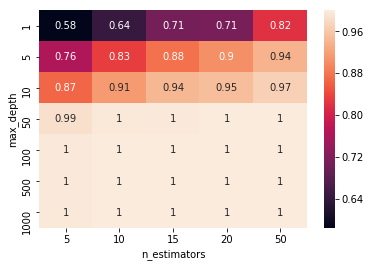

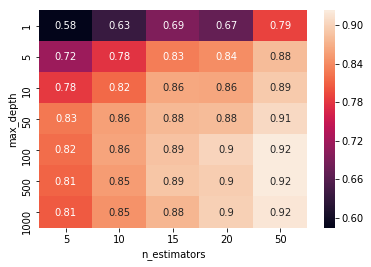

In [0]:



# get train & test score for different combination of alpha & Reg values.
# we are taking mean of score as we have 3 fold CV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,5),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,5),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()


* Above is the plot of **hyper parameters Vs Corresponding AUC_SCORE**.
* Note that, values printed in a grid like structure is an AUC_SCORE.
* We can notice that, there are multiple combinations of hyper parameters (max_depth & n_estimators) which gives best AUC_SCORE on train data.
* But There are few such combinations where we are geting AUC_SCORE > 0.9
* Looking at model performance on train & test data combined, **it seems that max_depth > 50 & n_estimators >20 suits the most.**

In [0]:
gd.best_params_

{'max_depth': 500, 'n_estimators': 50}

* As expetced we are getting best hyper parameters to be **max_depth=500 & n_estimators=50**

In [0]:
"""
# Now we will be building RandomForest classifier with previously obtained best parameters using GridSearchCV

model=RandomForestClassifier(oob_score=True,max_depth=500,n_estimators=50,class_weight='balanced')
model.fit(final_counts_train,final['Score'][:60000])"""

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
model.oob_score_

0.9177833333333333

* oob score seems to be **very good i.e.  >0.91**

In [0]:


pred_prob_train=model.predict_proba(final_counts_train)
pred_prob_test=model.predict_proba(final_counts_test)

pred_train=model.predict(final_counts_train)
pred_test=model.predict(final_counts_test)

In [0]:


from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

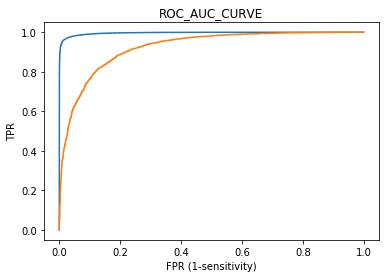

In [0]:


plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()

In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])


0.996434778796103
**************************************************


0.9232707244978786

* Notice that, model is performing **exceptionally well on train data with AUC=0.99**
* While on test data also, model is **doing well by giving an AUC_SCORE of 0.92 which is highly appreciated.**

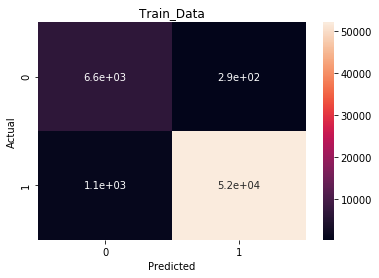

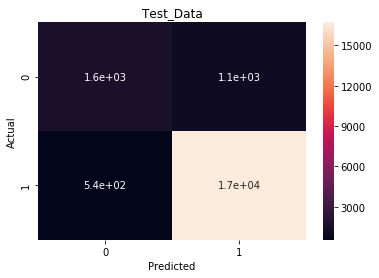

In [0]:


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

* Specifically evaluatiing model performance on positive & negative reviews, it seems that model is performing decent on both reviews on train data.
* Coming to test data, model has improved its performance on positive reviews but is performing even worst on negative reviews.
* Overall, we can say that, this model is doing **well for positive reviews but performing very poor on negative reviews.**

In [0]:

print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6853
           1       0.99      0.98      0.99     53147

    accuracy                           0.98     60000
   macro avg       0.93      0.97      0.95     60000
weighted avg       0.98      0.98      0.98     60000

######################################################################
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      2742
           1       0.94      0.97      0.95     17258

    accuracy                           0.92     20000
   macro avg       0.84      0.78      0.81     20000
weighted avg       0.91      0.92      0.91     20000



### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [0]:
features=count_vect.get_feature_names()
w=list(model.feature_importances_)
w_sorted=w.copy()
w_sorted.sort(reverse=True)




In [0]:
top_20_values=w_sorted[:20]
top_20_index=[w.index(i) for i in top_20_values]
top_20_features=[features[i] for i in top_20_index]

In [0]:
print(top_20_features)

['not', 'great', 'best', 'delicious', 'love', 'wonderful', 'bad', 'disappointed', 'excellent', 'loves', 'would', 'perfect', 'horrible', 'good', 'tasty', 'yummy', 'easy', 'awful', 'favorite', 'worst']


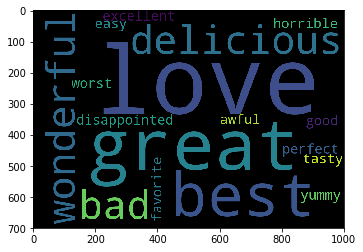

In [0]:
from wordcloud import WordCloud

graph=WordCloud(width=1000, height=700, margin=3).generate_from_text(" ".join(top_20_features))
plt.imshow(graph)
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param={'n_estimators':[5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

# Initialising a RandomForestClassifier
rf_model=RandomForestClassifier(oob_score=True,class_weight='balanced')
# Using GrridSearchCV for cross validation 
gd=GridSearchCV(rf_model,param_grid=param,cv=3,scoring='roc_auc',return_train_score=True)

# fitting the GridSearchCV on sample data size of 10k Datapoints.
gd.fit(final_tf_idf_train[:10000],final['Score'][:10000])


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
           

In [0]:
gd.cv_results_

{'mean_fit_time': array([0.03210537, 0.04634507, 0.06302389, 0.07697145, 0.16761883,
        0.0436422 , 0.0724802 , 0.09987028, 0.12772258, 0.30064646,
        0.06348681, 0.10757136, 0.15954391, 0.20341253, 0.48868688,
        0.19377271, 0.35589234, 0.53441564, 0.69583766, 1.7347858 ,
        0.23565952, 0.46094449, 0.68178511, 0.90648341, 2.30704347,
        0.25509214, 0.48724564, 0.73081827, 0.96198646, 2.38632854,
        0.25141128, 0.49634941, 0.72705976, 0.94951725, 2.39897664]),
 'mean_score_time': array([0.00747339, 0.01019804, 0.01312041, 0.01650524, 0.0334715 ,
        0.00712991, 0.01031327, 0.01346509, 0.01612528, 0.03411849,
        0.00791168, 0.01095152, 0.01483425, 0.01724577, 0.03764868,
        0.01002328, 0.01537633, 0.0207239 , 0.02628374, 0.05919449,
        0.0103662 , 0.01645509, 0.02249495, 0.0287195 , 0.06640164,
        0.01127688, 0.01723599, 0.0232811 , 0.02961938, 0.06760836,
        0.01083366, 0.01719125, 0.02364691, 0.0299166 , 0.06687291]),
 'mean_t

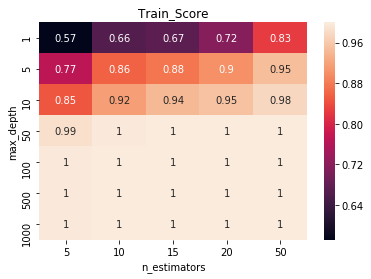

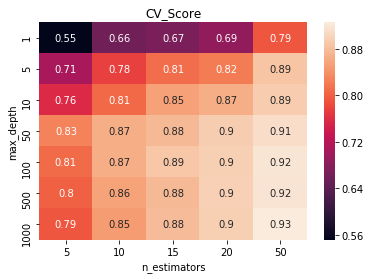

In [0]:

# get train & test score for different combination of alpha & Reg values.
# we are taking mean of score as we have 3 fold CV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,5),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,5),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()



In [0]:
gd.best_params_

{'max_depth': 1000, 'n_estimators': 50}

* Looking at above heatmap plot , it seems that higher the value of both hyper parameters better is the model performance.
* And finally using GridSearchCV we are getting **best hyper parameters to be max_depth=1000 & n_estimators=50**

In [0]:

# Now we will be building RandomForest classifier with previously obtained best parameters using GridSearchCV
# i.e max_depth=20 & n_estimators=50

model=RandomForestClassifier(oob_score=True,max_depth=1000,n_estimators=50,class_weight='balanced')
model.fit(final_tf_idf_train,final['Score'][:60000])

pred_prob_train=model.predict_proba(final_tf_idf_train)
pred_prob_test=model.predict_proba(final_tf_idf_test)

pred_train=model.predict(final_tf_idf_train)
pred_test=model.predict(final_tf_idf_test)


In [0]:
model.oob_score_
# Compare it with CV Score of best hyper parameters combination which is =0.93 i.e for 1000/50 -> max_depth/n_estimators

0.9203666666666667

* oob score is also good for this model as there is a very small difference between CV score & oob score. Therefore we could say that model is performing well with these values of hyper parameters.

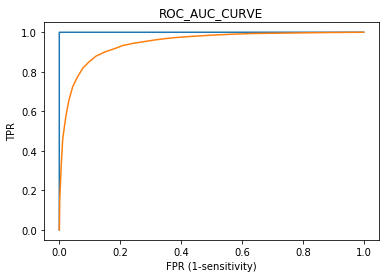

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()


In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9999321763088911
**************************************************


0.9445526970060673

* Again similar to previous model, this model is also performing very well on train data.
* Also **on test data it is giving better performance** than previous model.
* this model **seems to be well generalised.**

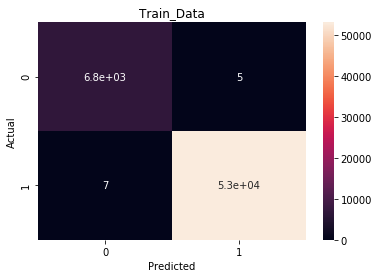

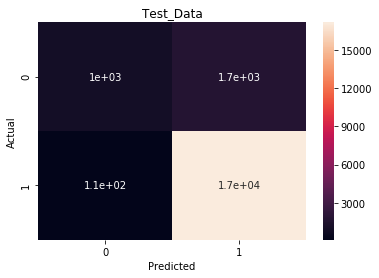

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* Again , confusion matrix also reflects the performance of model on train data. it is very well.
* But coming to **test data, model is performing comparatively poor specially with negative reviews.**
* while on positive reviews model is performing well on test data as well.

In [0]:

print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6853
           1       1.00      1.00      1.00     53147

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

######################################################################
              precision    recall  f1-score   support

           0       0.90      0.37      0.52      2742
           1       0.91      0.99      0.95     17258

    accuracy                           0.91     20000
   macro avg       0.90      0.68      0.74     20000
weighted avg       0.91      0.91      0.89     20000



### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [0]:
features=tf_idf_vect.get_feature_names()

w=list(model.feature_importances_)
w_sorted=w.copy()
w_sorted.sort(reverse=True)

top_20_values=w_sorted[:20]
top_20_index=[w.index(i) for i in top_20_values]
top_20_features=[features[i] for i in top_20_index]


In [0]:
print(top_20_features)

['great', 'not', 'best', 'delicious', 'love', 'good', 'excellent', 'would', 'disappointed', 'bad', 'wonderful', 'perfect', 'loves', 'tasty', 'favorite', 'easy', 'terrible', 'yummy', 'find', 'money']


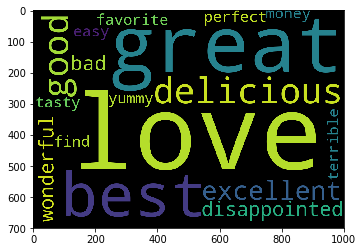

In [0]:
graph=WordCloud(width=1000,height=700).generate_from_text(" ".join(top_20_features))
plt.imshow(graph)
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1,5,10,50,100,500,1000]}

# Initialising a RandomForestClassifier
rf_model=RandomForestClassifier(oob_score=True,class_weight='balanced')
# Using GrridSearchCV for cross validation 
gd=GridSearchCV(rf_model,param_grid=param,cv=3,scoring='roc_auc',return_train_score=True)

# fitting the GridSearchCV on sample data size of 10k Datapoints.
gd.fit(avg_w2v_train_df[:10000],final['Score'][:10000])


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
           

In [0]:
gd.cv_results_

{'mean_fit_time': array([0.01507799, 0.03898899, 0.06916229, 0.09909121, 0.12891475,
        0.3066566 , 0.02799662, 0.10711877, 0.21018147, 0.30980221,
        0.41929603, 1.01542187, 0.0384686 , 0.15673939, 0.30587435,
        0.45382563, 0.60054509, 1.48421677, 0.04188728, 0.17471973,
        0.33933989, 0.51908978, 0.67664313, 1.66918715, 0.0402712 ,
        0.17164612, 0.33922148, 0.50828958, 0.67240644, 1.71715498,
        0.03975685, 0.17699154, 0.3368005 , 0.50368237, 0.66702747,
        1.66097633, 0.04096301, 0.17158945, 0.333016  , 0.50237632,
        0.6638631 , 1.65748398]),
 'mean_score_time': array([0.00377083, 0.00493431, 0.00609541, 0.00682386, 0.00783364,
        0.0133458 , 0.00390855, 0.00551152, 0.00733574, 0.00872906,
        0.01068409, 0.01942754, 0.0041995 , 0.00616733, 0.00842532,
        0.0105447 , 0.01293691, 0.02626673, 0.00417988, 0.00632548,
        0.0089438 , 0.01205293, 0.01440811, 0.02908055, 0.00407624,
        0.00637786, 0.00892011, 0.01141779, 0.

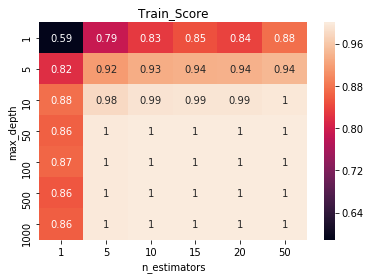

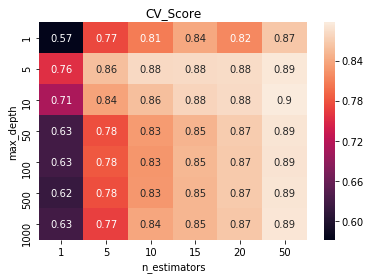

In [0]:

# get train & test score for different combination of alpha & Reg values.
# we are taking mean of score as we have 3 fold CV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()



In [0]:
gd.best_params_

{'max_depth': 10, 'n_estimators': 50}

* Looking at heatmap plot , it seems that this model is performing well on train data but comapred to previously 3 models it **showing slightly poor performance on test data** as there are very few combinations of hyper parameters for which AUC_SCORE >0.9 (for test data)

In [0]:

# Now we will be building RandomForest classifier with previously obtained best parameters using GridSearchCV
# i.e max_depth=20 & n_estimators=50

model=RandomForestClassifier(oob_score=True,max_depth=10,n_estimators=50,class_weight='balanced')
model.fit(avg_w2v_train_df,final['Score'][:60000])

pred_prob_train=model.predict_proba(avg_w2v_train_df)
pred_prob_test=model.predict_proba(avg_w2v_test_df)

pred_train=model.predict(avg_w2v_train_df)
pred_test=model.predict(avg_w2v_test_df)



In [0]:
model.oob_score_

0.8659833333333333

* We can notice the oob score , it reflects the exact same behavious as stated earlier. Performing slightly poor than previous 2 models.

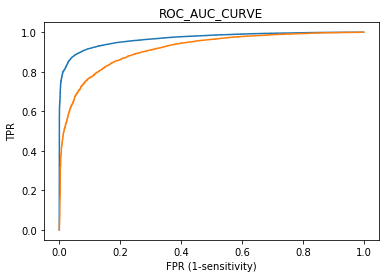

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()


In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9683155747924589
**************************************************


0.9156831588965305

* Look at the train data AUC_SCORE as well, it is lesser than previous 2 models
* But , to be noted, AUC_SCORE on test data though it is slightly lesser than previous models , it hasn't reduced much. **AUC_SCORE on test data is also very good >0.91.**

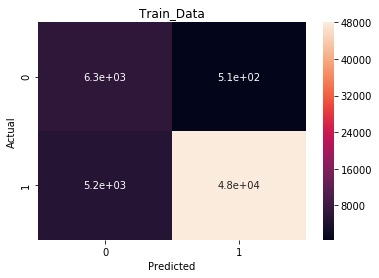

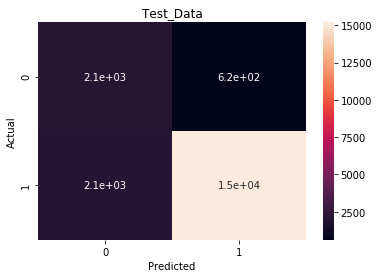

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



* Compared to previous 2 models this model is performing somewhat different.
* This model is performing **very decent on both reviews of train & test data as well.**
* This model though have lesser AUC_SCORE but **seems to be well generalised and a steady model than previous 2 models.**

In [0]:

print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       0.55      0.93      0.69      6853
           1       0.99      0.90      0.94     53147

    accuracy                           0.91     60000
   macro avg       0.77      0.91      0.82     60000
weighted avg       0.94      0.91      0.92     60000

######################################################################
              precision    recall  f1-score   support

           0       0.51      0.77      0.61      2742
           1       0.96      0.88      0.92     17258

    accuracy                           0.87     20000
   macro avg       0.73      0.83      0.77     20000
weighted avg       0.90      0.87      0.88     20000



### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

# Initialising a RandomForestClassifier
rf_model=RandomForestClassifier(oob_score=True,class_weight='balanced')
# Using GrridSearchCV for cross validation 
gd=GridSearchCV(rf_model,param_grid=param,cv=3,scoring='roc_auc',return_train_score=True)

# fitting the GridSearchCV on sample data size of 25k Datapoints.
gd.fit(tfidf_train_df[:10000],final['Score'][:10000])



GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
           

In [0]:
gd.cv_results_

{'mean_fit_time': array([0.01684205, 0.04209948, 0.07421064, 0.10699932, 0.14420819,
        0.31784383, 0.02777878, 0.11027257, 0.2093037 , 0.30741755,
        0.40492328, 1.00579373, 0.03734382, 0.15785909, 0.3131272 ,
        0.4588329 , 0.60537386, 1.49733488, 0.04133781, 0.1794006 ,
        0.34289734, 0.51189987, 0.6844875 , 1.70257378, 0.04265587,
        0.17506846, 0.34715541, 0.50877198, 0.6907262 , 1.71981104,
        0.04175798, 0.17667723, 0.34955033, 0.51527739, 0.68653115,
        1.70422713, 0.04274241, 0.17685429, 0.34777554, 0.51712187,
        0.68570383, 1.72474424]),
 'mean_score_time': array([0.00473658, 0.00558249, 0.00672841, 0.0075508 , 0.00866095,
        0.01404889, 0.00420785, 0.00569574, 0.00721224, 0.00866   ,
        0.01020328, 0.01917696, 0.00413831, 0.00634257, 0.00860993,
        0.01083239, 0.01330948, 0.02621969, 0.00416096, 0.00635568,
        0.00910807, 0.01174442, 0.01456467, 0.03012943, 0.00408673,
        0.00644811, 0.00936604, 0.01164341, 0.

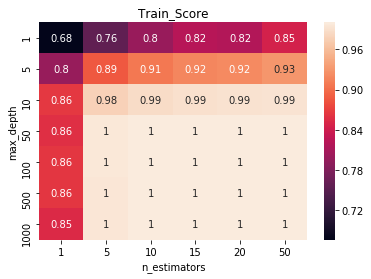

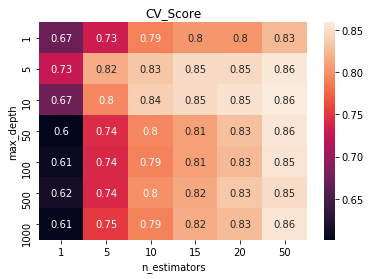

In [0]:
# get train & test score for different combination of alpha & Reg values.
# we are taking mean of score as we have 3 fold CV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()



In [0]:

gd.best_params_

{'max_depth': 10, 'n_estimators': 50}

* Again, we can notice that, on test data...**AUC_SCORE has reduced even more.**
* Stil performance on train data is good.
* Also note that, we are geting somewhat **lower values as a best hyper parameters.**

In [0]:

# Now we will be building RandomForest classifier with previously obtained best parameters using GridSearchCV
# i.e max_depth=20 & n_estimators=50

model=RandomForestClassifier(oob_score=True,max_depth=10,n_estimators=50,class_weight='balanced')
model.fit(tfidf_train_df,final['Score'][:60000])

pred_prob_train=model.predict_proba(tfidf_train_df)
pred_prob_test=model.predict_proba(tfidf_test_df)

pred_train=model.predict(tfidf_train_df)
pred_test=model.predict(tfidf_test_df)



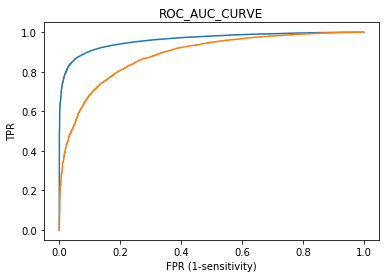

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()



In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9621595984130215
**************************************************


0.8859137326263726

* Performance on train data is very much similar to that of AVG_W2V based RF model.
* But model **performance has declined on test data by significant amount. < 0.9.**

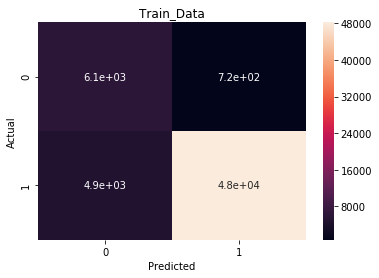

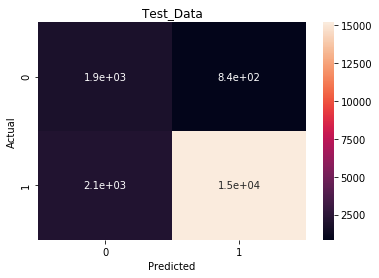

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* Coming to the model performance on specific reviews. it is performing decent on both the reviews. 
* Also there isn't much change in model performance on train & test data. steady performance.

In [0]:


print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6853
           1       0.99      0.91      0.94     53147

    accuracy                           0.91     60000
   macro avg       0.77      0.90      0.81     60000
weighted avg       0.94      0.91      0.91     60000

######################################################################
              precision    recall  f1-score   support

           0       0.48      0.69      0.56      2742
           1       0.95      0.88      0.91     17258

    accuracy                           0.85     20000
   macro avg       0.71      0.79      0.74     20000
weighted avg       0.88      0.85      0.86     20000



## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
!pip3 install xgboost

In [0]:
from xgboost import XGBClassifier

model=XGBClassifier()

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
gd=GridSearchCV(model,cv=3,param_grid=param,return_train_score=True)


In [0]:

# Lets implement GridSearchCV on 5k datapoints to get the best hyper parameters.

gd.fit(final_counts_train[:5000],final['Score'][:5000])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_

In [0]:
gd.cv_results_

{'mean_fit_time': array([ 0.06058272,  0.08169015,  0.11036857,  0.13790822,  0.16724245,
         0.33630013,  0.07733083,  0.17581685,  0.30552395,  0.43878063,
         0.56739434,  1.3244125 ,  0.10622764,  0.31240217,  0.59225575,
         0.86043715,  1.13866544,  2.70956977,  0.3107264 ,  1.29240314,
         2.4386433 ,  3.37530637,  4.29017909,  9.76440517,  0.35596085,
         1.44539944,  2.75734162,  3.66050371,  4.55748343, 10.18305731,
         0.35352174,  1.43460162,  2.721994  ,  3.66103101,  4.57677126,
        10.20516221,  0.35652129,  1.43359605,  2.74906238,  3.66564012,
         4.58954485, 10.18334794]),
 'mean_score_time': array([0.022614  , 0.02257204, 0.02281857, 0.0230267 , 0.0231328 ,
        0.02309608, 0.02258571, 0.02340269, 0.02450156, 0.02393985,
        0.02348042, 0.02582884, 0.02270357, 0.02296138, 0.02387206,
        0.02371995, 0.02500089, 0.02891334, 0.02311198, 0.0242881 ,
        0.02610286, 0.03212476, 0.02890976, 0.03728771, 0.02335461,
    

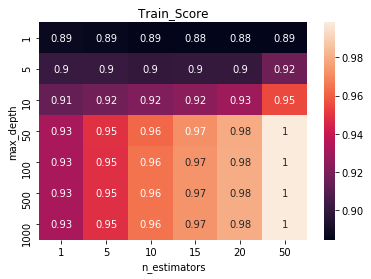

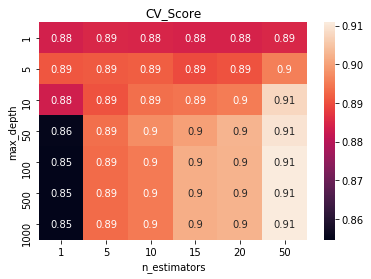

In [0]:

# get train & test score for different combination of alpha & Reg values.
# we are taking mean of score as we have 3 fold CV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()


In [0]:

gd.best_params_


{'max_depth': 100, 'n_estimators': 50}

* **Very First thing t be noted is that, Boost model (XGBClassifier) seems to be performing slightly poor than bagging (RandomForest) models, whwn it comes to AUC_SCORE on train data as there are very few AUC_SCORE of 1.0 unlike in RF models**.
* But again, just AUC_SCORE on train data doesnt tell everything about model performance.
* Look at the AUC_SCORE on test data, **unlike in Bagging model of RandomForest , this model has many AUC_SCORE >= 0.9 which is highly desirable.**
* We are geting **best hyper parameters to be max_depth=100 & n_estimators=50**

In [0]:

# Now we will be building XGBoost classifier with previously obtained best parameters using GridSearchCV

model=XGBClassifier(max_depth=100,n_estimators=50)
model.fit(final_counts_train,final['Score'][:60000])

pred_prob_train=model.predict_proba(final_counts_train)
pred_prob_test=model.predict_proba(final_counts_test)

pred_train=model.predict(final_counts_train)
pred_test=model.predict(final_counts_test)



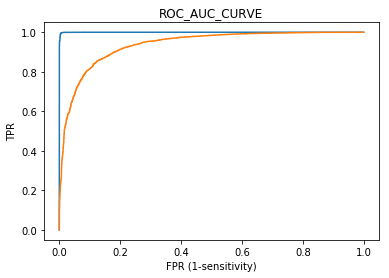

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()



In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9998105590475745
**************************************************


0.9366402257953458

* Though there are very less combination sof hyper parameters giving best AUC_SCORE , this best hyper parameter seems to be performing well on train data.
* Also AUC_SCORE on test data is very good.
* Model seems to be well generalised as well.

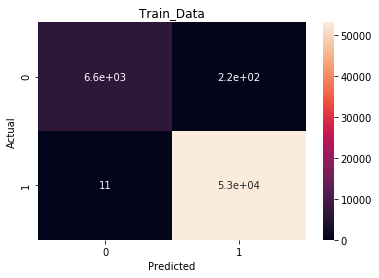

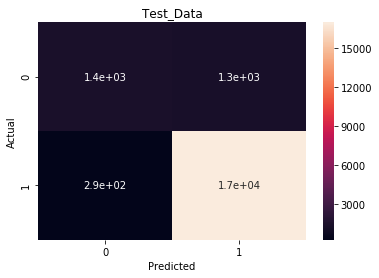

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* Though model performance on train data is very well but model is **disappointing when it comes to test data.**
* Specially , model performance on negative reviews from test data is much poor. while model is performing better on positive reviews.

In [0]:


print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6853
           1       0.98      1.00      0.99     53147

    accuracy                           0.98     60000
   macro avg       0.98      0.91      0.94     60000
weighted avg       0.98      0.98      0.98     60000

######################################################################
              precision    recall  f1-score   support

           0       0.76      0.38      0.50      2742
           1       0.91      0.98      0.94     17258

    accuracy                           0.90     20000
   macro avg       0.83      0.68      0.72     20000
weighted avg       0.89      0.90      0.88     20000



### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
from xgboost import XGBClassifier

model=XGBClassifier()

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

gd=GridSearchCV(model,cv=3,param_grid=param,return_train_score=True)

# Lets implement GridSearchCV on 5k datapoints to get the best hyper parameters.

gd.fit(final_tf_idf_train[:5000],final['Score'][:5000])



GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_

In [0]:
gd.cv_results_

{'mean_fit_time': array([ 0.06435005,  0.09527222,  0.13421543,  0.17622296,  0.21153243,
         0.44767388,  0.09103386,  0.23453013,  0.41259956,  0.59248797,
         0.77677131,  1.83274849,  0.1271166 ,  0.42215188,  0.80454357,
         1.17074593,  1.5334243 ,  3.62390995,  0.39600325,  1.73097459,
         3.29586339,  4.51245975,  5.58976396, 11.90930359,  0.62609537,
         2.6004831 ,  4.3756423 ,  5.71999113,  6.80193154, 13.05084594,
         0.6290261 ,  2.60381285,  4.36451618,  5.68591611,  6.81388489,
        13.02156027,  0.62687333,  2.60383217,  4.37239679,  5.69126312,
         6.81745172, 13.16471847]),
 'mean_score_time': array([0.02357801, 0.02273472, 0.02245498, 0.0231727 , 0.02246769,
        0.02418327, 0.02220265, 0.02243948, 0.02266717, 0.02267464,
        0.02298156, 0.02494001, 0.0220139 , 0.02349289, 0.02337042,
        0.02336383, 0.02483304, 0.02965331, 0.02333188, 0.02496648,
        0.02666386, 0.02870186, 0.02963988, 0.03931642, 0.02299349,
    

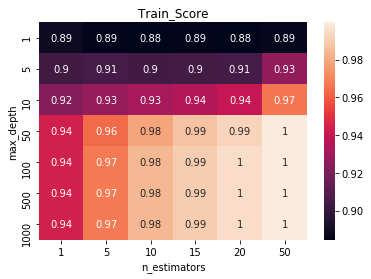

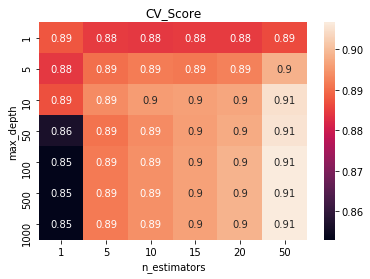

In [0]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()


In [0]:
gd.best_params_

{'max_depth': 100, 'n_estimators': 50}

* It seems that , AUC_SCORE on test data has slightly reduced than previous model.
* Though **overall performance seems very much similar to previous model**, also best tuned hyper parameters are also same for both the boosting models.

In [0]:

# Now we will be building XGBoost classifier with previously obtained best parameters using GridSearchCV

model=XGBClassifier(max_depth=100,n_estimators=50)
model.fit(final_tf_idf_train[:60000],final['Score'][:60000])

pred_prob_train=model.predict_proba(final_tf_idf_train)
pred_prob_test=model.predict_proba(final_tf_idf_test)

pred_train=model.predict(final_tf_idf_train)
pred_test=model.predict(final_tf_idf_test)



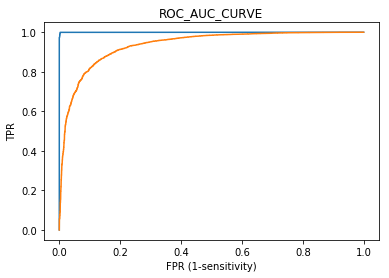

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()



In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9999510771606102
**************************************************


0.935583410866906

* It is very much clear that, this model is **performing very much similar to that of previous model. **
* Both models have almost same AUC_SCORE on both train & test data.


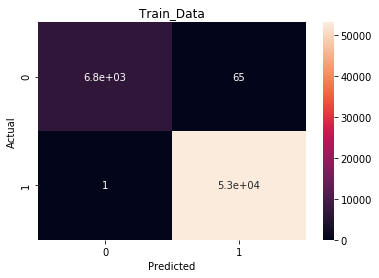

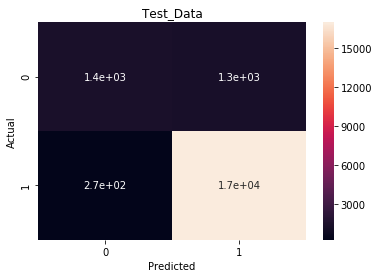

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* But again, similar to previous model this model is also **disappointing when it comes to model performance on specific review** i.e. positive & negative review.
* **Overall these 2 models are , more or less, performing exactly same.**

In [0]:


print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6853
           1       1.00      1.00      1.00     53147

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

######################################################################
              precision    recall  f1-score   support

           0       0.84      0.51      0.63      2742
           1       0.93      0.98      0.95     17258

    accuracy                           0.92     20000
   macro avg       0.88      0.75      0.79     20000
weighted avg       0.91      0.92      0.91     20000



### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:

from xgboost import XGBClassifier

model=XGBClassifier()

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

gd=GridSearchCV(model,cv=3,param_grid=param,return_train_score=True)

# Lets implement GridSearchCV on 5k datapoints to get the best hyper parameters.

gd.fit(avg_w2v_train_df[:5000],final['Score'][:5000])


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_

In [0]:
gd.cv_results_

{'mean_fit_time': array([0.03377732, 0.05127962, 0.07452329, 0.0963215 , 0.11858686,
        0.25443395, 0.04601447, 0.11618789, 0.20596552, 0.301495  ,
        0.38887413, 0.98148886, 0.06266038, 0.19693645, 0.36866895,
        0.54580696, 0.72497455, 1.68849953, 0.0663987 , 0.21455908,
        0.41229908, 0.60675875, 0.80604315, 1.84232608, 0.06538455,
        0.21392767, 0.41223923, 0.61325987, 0.79977314, 1.8353955 ,
        0.0655961 , 0.21692856, 0.4165651 , 0.60602482, 0.7998933 ,
        1.84695737, 0.07191253, 0.2144982 , 0.41204826, 0.60806926,
        0.80463219, 1.85097114]),
 'mean_score_time': array([0.00478133, 0.00458344, 0.00467952, 0.00482726, 0.00483195,
        0.00593098, 0.00459297, 0.00483966, 0.00516518, 0.00570854,
        0.00614985, 0.00891232, 0.004613  , 0.00506194, 0.00583545,
        0.00664846, 0.007526  , 0.01248654, 0.00494099, 0.00500234,
        0.00577895, 0.007025  , 0.00760253, 0.01266162, 0.00459647,
        0.00498684, 0.00595427, 0.00672698, 0.

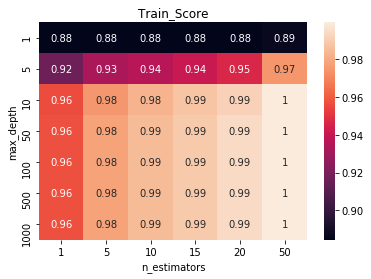

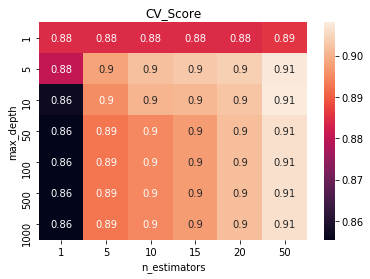

In [0]:


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()


In [0]:
gd.best_params_

{'max_depth': 10, 'n_estimators': 50}

* This model seems to be performing well on multiple combinations of hyper parameters.
* Still the best hyper parameters are **max_depth=10 & n_estimators=50**

In [0]:

# Now we will be building XGBoost classifier with previously obtained best parameters using GridSearchCV

model=XGBClassifier(max_depth=10,n_estimators=50)
model.fit(avg_w2v_train_df[:60000],final['Score'][:60000])

pred_prob_train=model.predict_proba(avg_w2v_train_df)
pred_prob_test=model.predict_proba(avg_w2v_test_df)

pred_train=model.predict(avg_w2v_train_df)
pred_test=model.predict(avg_w2v_test_df)



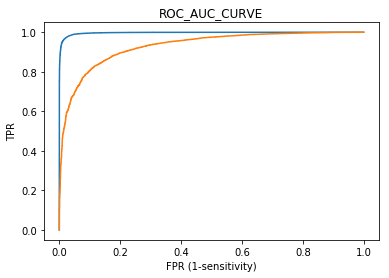

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()



In [0]:

print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9973412303127237
**************************************************


0.929825787619801

* Again this model is **performing very much similar to previous 2 models.**
* Only difference is that, this model is **slightly performing poor on test data**, compared to previous 2 models.

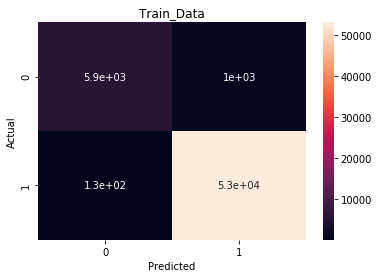

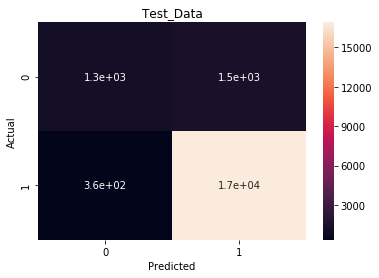

In [0]:

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* Performance on positive & negative reviews from train data is decent, in fact it is not good on negative reviews compared to positive reviews.
* While on test data, model is showing same performance similar to that on train data.
* Compared to previous 2 models , this model though **performing poor on train data** , but then **on test data, all 3 models are performing very much similar.**


In [0]:

print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      6853
           1       0.98      1.00      0.99     53147

    accuracy                           0.98     60000
   macro avg       0.98      0.93      0.95     60000
weighted avg       0.98      0.98      0.98     60000

######################################################################
              precision    recall  f1-score   support

           0       0.78      0.46      0.58      2742
           1       0.92      0.98      0.95     17258

    accuracy                           0.91     20000
   macro avg       0.85      0.72      0.76     20000
weighted avg       0.90      0.91      0.90     20000



### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:

from xgboost import XGBClassifier

model=XGBClassifier()

param={'n_estimators':[1,5,10,15,20,50],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}

gd=GridSearchCV(model,cv=3,param_grid=param,return_train_score=True)

# Lets implement GridSearchCV on 5k datapoints to get the best hyper parameters.

gd.fit(tfidf_train_df[:5000],final['Score'][:5000])


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_

In [0]:
gd.cv_results_

{'mean_fit_time': array([0.03356361, 0.05093002, 0.07476044, 0.09742904, 0.11941473,
        0.26322182, 0.0458862 , 0.11536805, 0.20671248, 0.29636796,
        0.39204764, 0.98050912, 0.06261142, 0.20236246, 0.36386665,
        0.54308041, 0.71415464, 1.69068416, 0.0738047 , 0.20929201,
        0.40319586, 0.59048176, 0.78264197, 1.85353684, 0.06886768,
        0.21049452, 0.40817308, 0.59598629, 0.78486832, 1.85374212,
        0.06859914, 0.2088093 , 0.40197738, 0.59408768, 0.77575541,
        1.85457357, 0.0686121 , 0.20945708, 0.40672501, 0.58972851,
        0.78399126, 1.86220384]),
 'mean_score_time': array([0.00482933, 0.00457899, 0.00469549, 0.00476599, 0.00501823,
        0.00602778, 0.00458519, 0.0048697 , 0.00562827, 0.00585985,
        0.0061214 , 0.00899259, 0.00465202, 0.00513689, 0.00573428,
        0.00648053, 0.00767835, 0.01244736, 0.00459425, 0.00502157,
        0.00635751, 0.00658178, 0.00766055, 0.01269555, 0.00478141,
        0.00521866, 0.00579643, 0.00667572, 0.

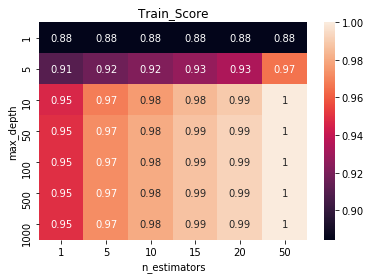

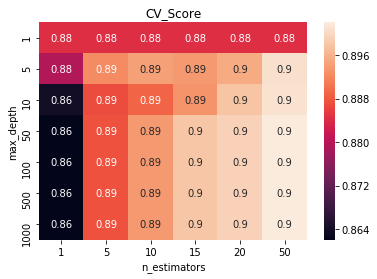

In [0]:


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_score=gd.cv_results_['mean_train_score']
cv_score=gd.cv_results_['mean_test_score']

sns.heatmap(train_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("Train_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()
sns.heatmap(cv_score.reshape(7,6),annot=True,yticklabels=param['max_depth'],xticklabels=param['n_estimators'])
plt.title("CV_Score")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()


In [0]:
gd.best_params_

{'max_depth': 50, 'n_estimators': 50}

* This model again giving dfferent values as a best hyper parameters.
* **max_depth=50 & n_estimators=50**

In [0]:

# Now we will be building XGBoost classifier with previously obtained best parameters using GridSearchCV

model=XGBClassifier(max_depth=50,n_estimators=50)
model.fit(tfidf_train_df[:60000],final['Score'][:60000])

pred_prob_train=model.predict_proba(tfidf_train_df)
pred_prob_test=model.predict_proba(tfidf_test_df)

pred_train=model.predict(tfidf_train_df)
pred_test=model.predict(tfidf_test_df)



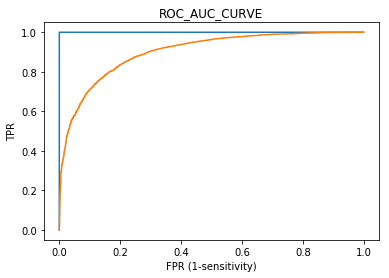

In [0]:

from sklearn.metrics import roc_auc_score

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.show()


In [0]:


print(roc_auc_score(final['Score'][:60000],pred_prob_train[:,1]))
print(50*'*')
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])


0.9999969729533671
**************************************************


0.9010004155410668

* This model is also performing very well on train data.
* But on test data, this **model is giving comparatively lower AUC_SCORE**


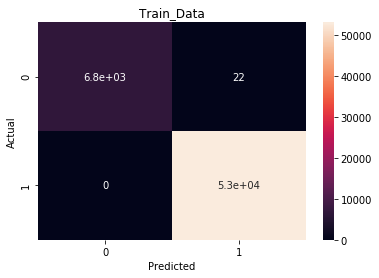

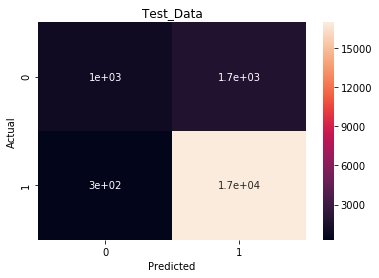

In [0]:


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat_train=confusion_matrix(final['Score'][:60000],pred_train)
cmat_test=confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_train,annot=True)
plt.title("Train_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
sns.heatmap(cmat_test,annot=True)
plt.title("Test_Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


* This model is behaving **almost similar to BOW & TFIDF based XGBClassifier.**
* Model is performing very different on train & test data when it comes to predict positive & negative reviews.
* Model is showing **very high variance from train data to test data like BOW & TFIDF based models , unlike AVG_W2V based model.**


In [0]:

print(classification_report(final['Score'][:60000],pred_train))

print(70*'#')

print(classification_report(final['Score'][60000:80000],pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6853
           1       1.00      1.00      1.00     53147

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

######################################################################
              precision    recall  f1-score   support

           0       0.77      0.36      0.49      2742
           1       0.91      0.98      0.94     17258

    accuracy                           0.90     20000
   macro avg       0.84      0.67      0.72     20000
weighted avg       0.89      0.90      0.88     20000



# [6] Conclusions

**1. Random Forest (Bagging & Aggregation) :-**
* BOW based RF model is performing decent on train & test data. Also showing good performance when it comes to specifically predicting positive & negative reviews.
* **TFIDF based RF model seems to be performing even better than BOW based mode**l, as AUC_SCORE on test data is better in this case with almost same AUC_SCORE on train data.
* While on positive & negative reviews both these models are performing almost similar.
* **AVG_W2V based RF model is slightly performing poor than above 2 models**.
* While **TFIDF_W2V based RF model is performing even more poor than above 3 models.**

**2. GBDT/XGBoost/XGBClassifier (Boosting):-**
* It is very much evident from the model performances that, **AVG_W2V model seems to be performing competitively same when compared with BOW & TFIDF based models**. In fact it is **better on test data than TFIDF_W2V based model.**
* When it comes to ability of being generalised. BOW based model seems to be performing better as there is a **small difference between train & test score than other 3 models**.



# Important Features (From RF Models)

In [0]:
from prettytable import PrettyTable
table_pos=PrettyTable()
table_neg=PrettyTable()


In [0]:
index=["tokenization",1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]





bow=['BOW','great', 'not', 'best', 'delicious', 'love', 'good', 'excellent', 'would', 'disappointed', 'bad', 'wonderful', 'perfect', 'loves', 'tasty', 'favorite', 'easy', 'terrible', 'yummy', 'find', 'money']

tfidf=['TFIDF','not', 'great', 'best', 'delicious', 'love', 'wonderful', 'bad', 'disappointed', 'excellent', 'loves', 'would', 'perfect', 'horrible', 'good', 'tasty', 'yummy', 'easy', 'awful', 'favorite', 'worst']

table_pos.add_column("class label",index)
table_pos.add_column("Positive",bow)
table_pos.add_column("Positive",tfidf)

In [0]:
print(table_pos)

+--------------+--------------+--------------+
| class label  |   Positive   |   Positive   |
+--------------+--------------+--------------+
| tokenization |     BOW      |    TFIDF     |
|      1       |    great     |     not      |
|      2       |     not      |    great     |
|      3       |     best     |     best     |
|      4       |  delicious   |  delicious   |
|      5       |     love     |     love     |
|      6       |     good     |  wonderful   |
|      7       |  excellent   |     bad      |
|      8       |    would     | disappointed |
|      9       | disappointed |  excellent   |
|      10      |     bad      |    loves     |
|      11      |  wonderful   |    would     |
|      12      |   perfect    |   perfect    |
|      13      |    loves     |   horrible   |
|      14      |    tasty     |     good     |
|      15      |   favorite   |    tasty     |
|      16      |     easy     |    yummy     |
|      17      |   terrible   |     easy     |
|      18    

* Most of the top features are same except few which are unique for each model.


# Score Evaluation

In [0]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=["Vectorization","--","RandomForest(Bagging)"]
#print(table)
table.add_row(["---","Train","Test"])
#print(table)



bow=["BOW", 0.9964,0.9232]
tfidf=["TFIDF",0.9999,0.9445]
avgw2v=['AVG_W2V',0.9683,0.9156]
tfidfw2v=['TFIDF_W2V',0.9621,0.8859]

table.add_row(bow)
table.add_row(tfidf)
table.add_row(avgw2v)
table.add_row(tfidfw2v)

print(table)

+---------------+--------+-----------------------+
| Vectorization |   --   | RandomForest(Bagging) |
+---------------+--------+-----------------------+
|      ---      | Train  |          Test         |
|      BOW      | 0.9964 |         0.9232        |
|     TFIDF     | 0.9999 |         0.9445        |
|    AVG_W2V    | 0.9683 |         0.9156        |
|   TFIDF_W2V   | 0.9621 |         0.8859        |
+---------------+--------+-----------------------+


In [0]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=["Vectorization","GBDT/XGBClassifier","-"]
#print(table)
table.add_row(["---","Train","Test"])
#print(table)

bow=["BOW",0.9998,0.9366]
tfidf=["TFIDF",0.9999,0.9355]
avgw2v=['AVG_W2V',0.9973,0.9298]
tfidfw2v=['TFIDF_W2V',0.9999,0.9010]

table.add_row(bow)
table.add_row(tfidf)
table.add_row(avgw2v)
table.add_row(tfidfw2v)

print(table)

+---------------+--------------------+--------+
| Vectorization | GBDT/XGBClassifier |   -    |
+---------------+--------------------+--------+
|      ---      |       Train        |  Test  |
|      BOW      |       0.9998       | 0.9366 |
|     TFIDF     |       0.9999       | 0.9355 |
|    AVG_W2V    |       0.9973       | 0.9298 |
|   TFIDF_W2V   |       0.9999       | 0.901  |
+---------------+--------------------+--------+


# Final Thoughts:-

**1. Random Forest (Bagging):-**

* Looking at all 4 models performance and the obseravtions made so far, **TFIDF based RF model seems to be the best choice.**

**2. GBDT/XGBClassifier (Boosting):-**
* SImilarly, for Boosting technique based XGBClassifier model, **BOW based model seems to be the best model.**
* Though TFIDF in this case is very much competive to BOW based model as these 2 models are performing very much similar.